## Descripción del problema
Poniéndonos en la situación de que somos parte del equipo de la empresa Rent-Cycle en Wachington DC, y nuestro Team Leader nos da la tarea de implementar un modelo que nos permita predecir la cantidad de bicicletas que se alquilan según la información contenida en el dataset puesto a disposición.

### Archivos provistos
Se proveen los archivos:

'Bike_train.xlsx', con 11999 observaciones y 17 dimensiones, incluyendo la cantidad de bicicletas rentadas en el momento del registro.
'Bike_test.xlsx', con 5380 observaciones y 16 dimensiones, sin incluir la cantidad de bicicletas rentadas en el momento del registro.
Descripción de las di

In [762]:
import datetime as dt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn import preprocessing,metrics
from sklearn.model_selection import cross_val_score,cross_val_predict,train_test_split
from sklearn.ensemble import RandomForestRegressor
import math

In [763]:
# lectura de archivo de entrenamiento
df_train = pd.read_excel('bike_train.xlsx')


In [764]:
df_train.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [765]:
# se observa que no existen valores nulos y que casi todas las variables son numericas
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11999 entries, 0 to 11998
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     11999 non-null  int64         
 1   dteday      11999 non-null  datetime64[ns]
 2   season      11999 non-null  int64         
 3   yr          11999 non-null  int64         
 4   mnth        11999 non-null  int64         
 5   hr          11999 non-null  int64         
 6   holiday     11999 non-null  int64         
 7   weekday     11999 non-null  int64         
 8   workingday  11999 non-null  int64         
 9   weathersit  11999 non-null  int64         
 10  temp        11999 non-null  float64       
 11  atemp       11999 non-null  float64       
 12  hum         11999 non-null  float64       
 13  windspeed   11999 non-null  float64       
 14  casual      11999 non-null  int64         
 15  registered  11999 non-null  int64         
 16  cnt         11999 non-

In [766]:
# no hay nulos
df_train.isna().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [767]:
df_train['dteday']=df_train['dteday'].map(dt.datetime.toordinal)
df_train['season']=df_train.season.astype('category')
df_train['yr']=df_train.yr.astype('category')
df_train['mnth']=df_train.mnth.astype('category')
df_train['hr']=df_train.hr.astype('category')
df_train['holiday']=df_train.holiday.astype('category')
df_train['weekday']=df_train.weekday.astype('category')
df_train['workingday']=df_train.workingday.astype('category')
df_train['weathersit']=df_train.weathersit.astype('category')

In [768]:
# todos los valores se encuentra dentro de los rangos definidos en la Descripción de las dimensiones de archivo README.md
df_train.describe()

,instant,dteday,temp,atemp,hum,windspeed,casual,registered,cnt
count,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000
mean,6000.000000,734391.626219,0.465704,0.448888,0.625770,0.196433,30.049837,128.545129,158.594966
std,3463.957275,145.218201,0.188576,0.169633,0.200637,0.125394,43.596915,124.692750,151.392952
min,1.000000,734138.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,3000.500000,734266.000000,0.320000,0.303000,0.470000,0.104500,3.000000,29.000000,34.000000
50%,6000.000000,734392.000000,0.460000,0.454500,0.620000,0.194000,13.000000,98.000000,118.000000
75%,8999.500000,734517.000000,0.620000,0.590900,0.790000,0.283600,39.000000,185.000000,232.000000
max,11999.000000,734643.000000,0.960000,1.000000,1.000000,0.850700,367.000000,770.000000,957.000000


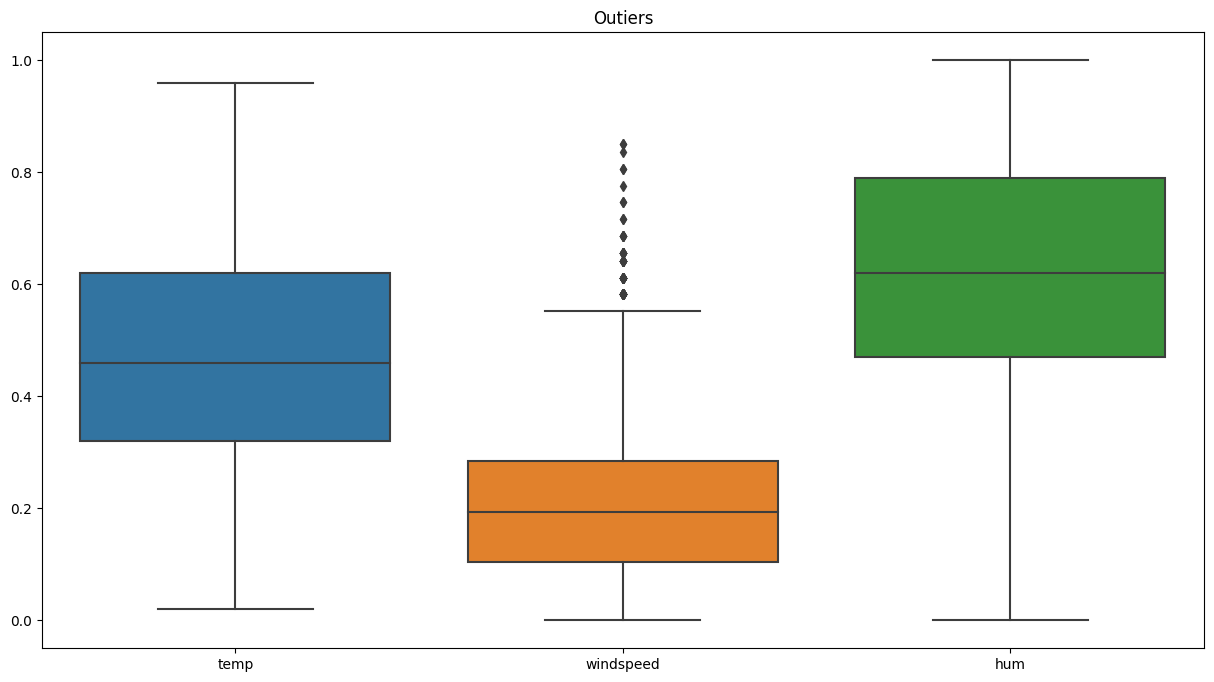

In [769]:
# Deteccion de Outliers de valores normalizados
fig,ax=plt.subplots(figsize=(15,8))
sns.boxplot(data=df_train[['temp','windspeed','hum']])
ax.set_title('Outiers')
plt.show()

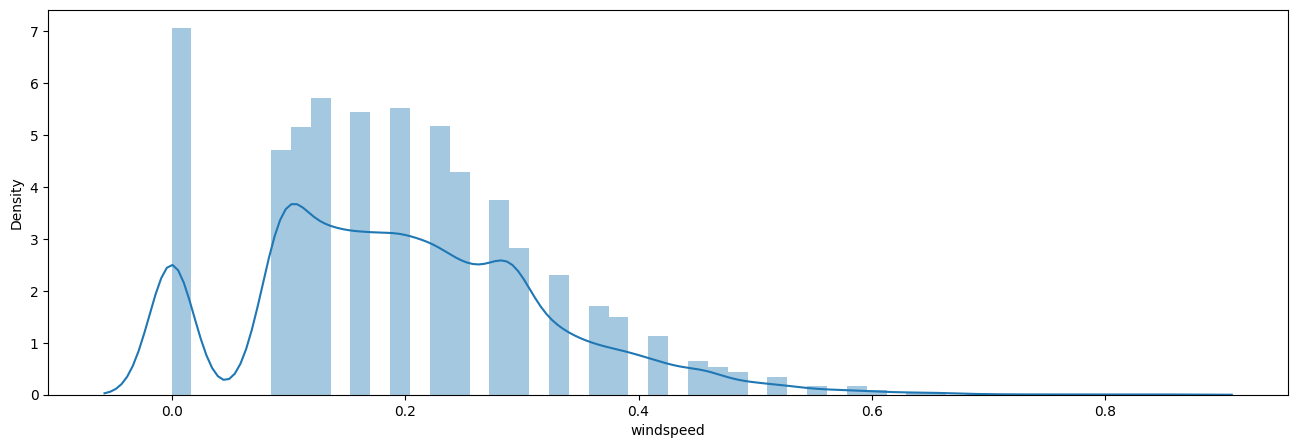

In [770]:
# se grafica la distribucion de la variable windspeed al ser la unica que presenta outliers
plt.figure(figsize=(16,5))
sns.distplot(df_train['windspeed'])
plt.show()

In [771]:
''''
#Se filtran outliers usando Z-score 
upper_limit = df_train['windspeed'].mean() + 3*df_train['windspeed'].std()
lower_limit = df_train['windspeed'].mean() - 3*df_train['windspeed'].std()
df_train['windspeed'] = np.where(
    df_train['windspeed']>upper_limit,
    upper_limit,
    np.where(
        df_train['windspeed']<lower_limit,
        lower_limit,
        df_train['windspeed']
    )
)
'''

"'\n#Se filtran outliers usando Z-score \nupper_limit = df_train['windspeed'].mean() + 3*df_train['windspeed'].std()\nlower_limit = df_train['windspeed'].mean() - 3*df_train['windspeed'].std()\ndf_train['windspeed'] = np.where(\n    df_train['windspeed']>upper_limit,\n    upper_limit,\n    np.where(\n        df_train['windspeed']<lower_limit,\n        lower_limit,\n        df_train['windspeed']\n    )\n)\n"

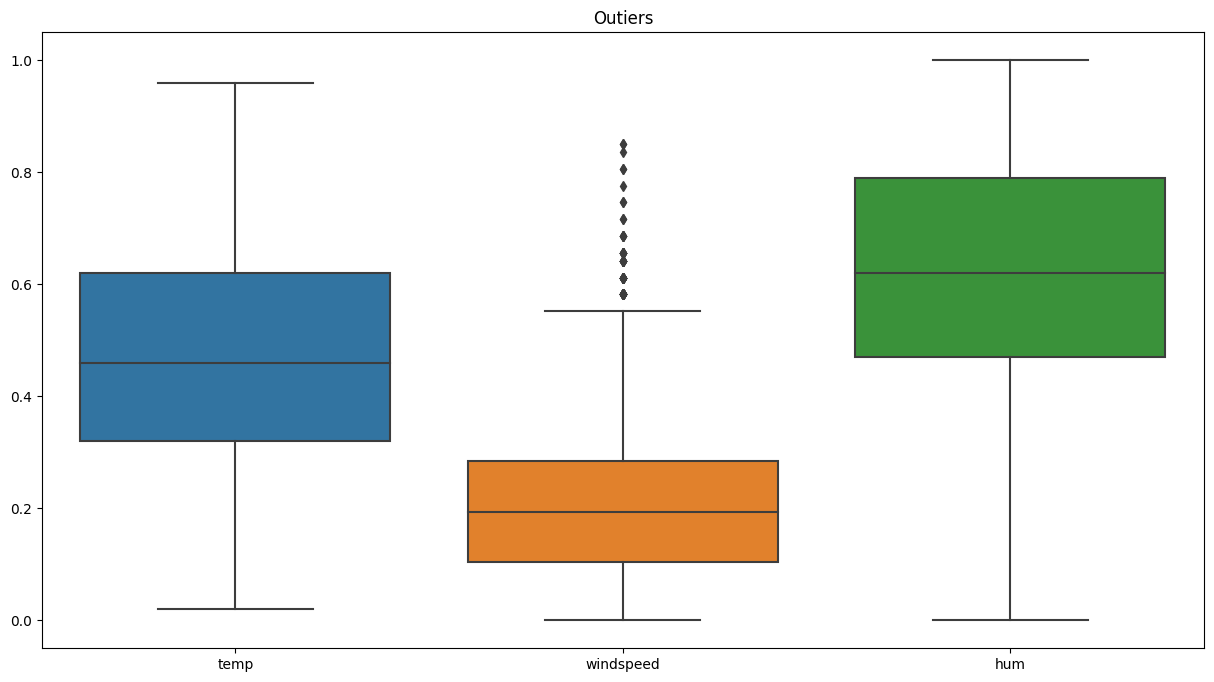

In [772]:
# Outliers despues de aplicar filtro
fig,ax=plt.subplots(figsize=(15,8))
sns.boxplot(data=df_train[['temp','windspeed','hum']])
ax.set_title('Outiers')
plt.show()

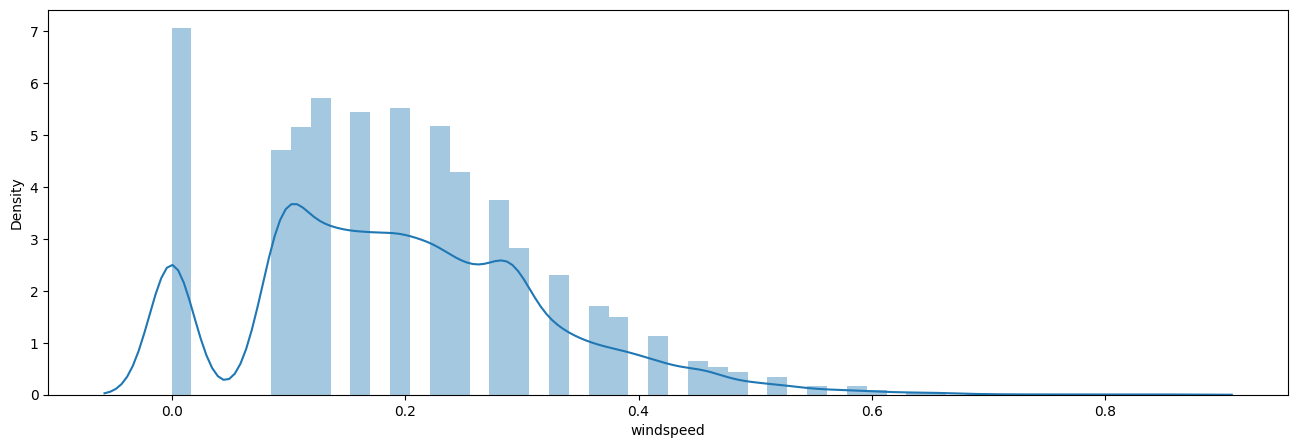

In [773]:
# grafica de distribucion de la variables windspeed
plt.figure(figsize=(16,5))
sns.distplot(df_train['windspeed'])
plt.show()

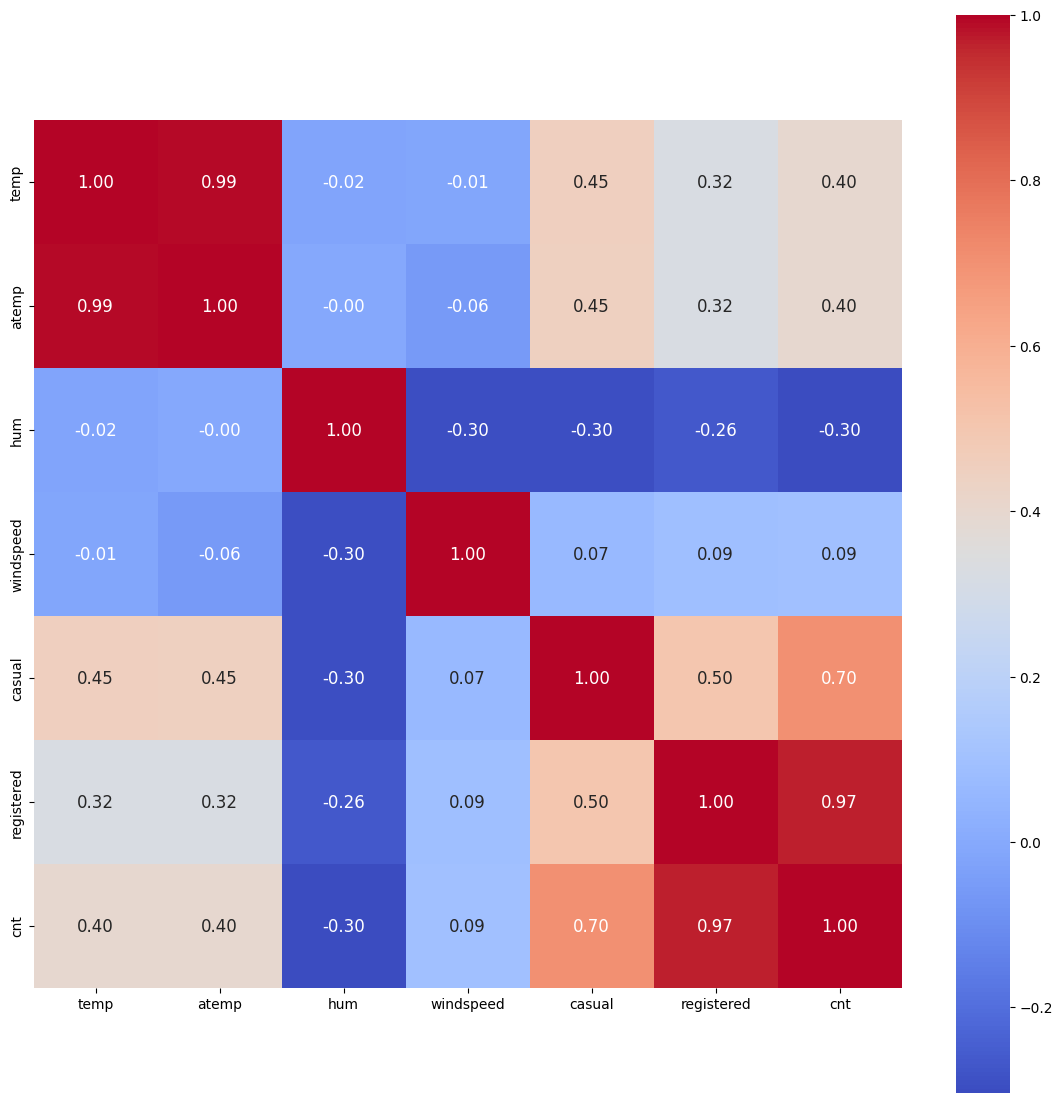

In [774]:
#correlacion entre variables
corr = df_train[["temp","atemp","hum","windspeed","casual","registered","cnt"]].corr()
plt.figure(figsize=(14,14))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 12},
           cmap= 'coolwarm')

plt.show()

In [794]:
# se separa la variable categorica season
df = df_train.copy()
df = pd.concat([df, pd.get_dummies(df['season'])], axis=1)
df = df.rename(columns={1:'primavera',2:'verano',3:'otonio',4:'invierno'})
df = df.drop(columns='season')
# se separa la variable categorica yr
df = pd.concat([df, pd.get_dummies(df['yr'])], axis=1)
df = df.rename(columns={0:'anio_2011',1:'anio_2012'})
df = df.drop(columns='yr')
# se separa la variable categorica holiday
df = pd.concat([df, pd.get_dummies(df['holiday'])], axis=1)
df = df.rename(columns={0:'no_feriado',1:'feriado'})
df = df.drop(columns='holiday')
# se separa la variable categorica workingday
df = pd.concat([df, pd.get_dummies(df['workingday'])], axis=1)
df = df.rename(columns={0:'no_laboral',1:'laboral'})
df = df.drop(columns='workingday')
# se separa la variable categorica season
df = pd.concat([df, pd.get_dummies(df['weathersit'])], axis=1)
df = df.rename(columns={1:'despejado',2:'neblina',3:'nieve',4:'lluvia'})
df = df.drop(columns='weathersit')


In [795]:
columnas = df.drop(columns=['instant','dteday','casual','registered','cnt']).columns.values
X = df[columnas]
y = df['cnt']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [796]:
clf=RandomForestRegressor(n_estimators=200)
clf.fit(X_train,y_train)

RandomForestRegressor(n_estimators=200)

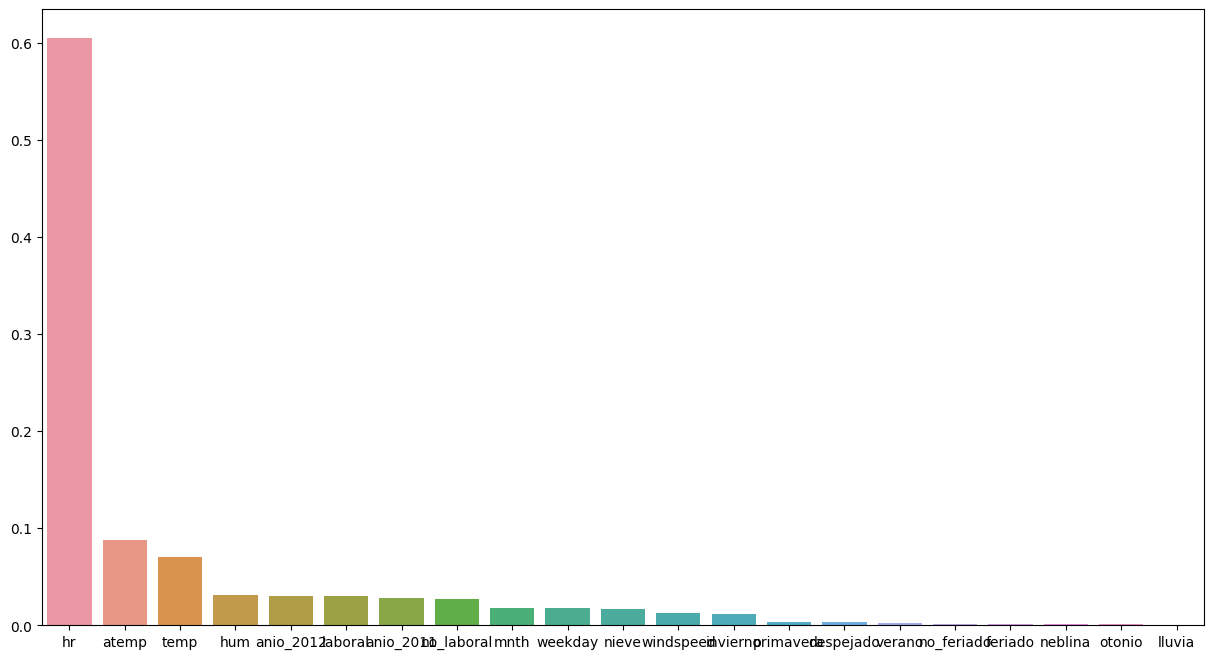

In [797]:
importances = clf.feature_importances_
columns = X_train.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize = (15,8))
sns.barplot(columns[indices], importances[indices])
plt.show()

In [798]:
columnas = ['mnth', 'hr', 'temp', 'atemp', 'hum', 'windspeed', 'no_feriado', 'feriado', 'no_laboral', 'laboral']
X = df[columnas]
y = df['cnt']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [799]:
clf=RandomForestRegressor(n_estimators=200)
clf.fit(X_train,y_train)

RandomForestRegressor(n_estimators=200)

In [800]:
#accuracy del modelo model
rf_score =clf.score(X_train,y_train)
print('Accuracy of the model :',rf_score)

Accuracy of the model : 0.9800824852551423


In [801]:

y_test_pred=clf.predict(X_test)
#Root mean square error
rmse = math.sqrt(metrics.mean_squared_error(y_test,y_test_pred))
print('Root mean square error :',rmse)
#Mean absolute error
mae=metrics.mean_absolute_error(y_test,y_test_pred)
print('Mean absolute error :',mae)


Root mean square error : 56.50752531626188
Mean absolute error : 35.91503228505291


In [802]:
df = pd.DataFrame({'Real': y_test, 'Predicted': y_test_pred})
df


,Real,Predicted
1935,125,166.915000
6494,8,6.095000
1720,299,509.640000
9120,72,58.890000
360,104,188.953333
...,...,...
9136,95,104.595000
9169,37,32.575000
9419,228,234.526333
3817,107,103.605000


In [803]:
# lectura de archivo de prueba
df_test = pd.read_excel('bike_test.xlsx')

df_test['dteday']=df_test['dteday'].map(dt.datetime.toordinal)
df_test['season']=df_test.season.astype('category')
df_test['yr']=df_test.yr.astype('category')
df_test['mnth']=df_test.mnth.astype('category')
df_test['hr']=df_test.hr.astype('category')
df_test['holiday']=df_test.holiday.astype('category')
df_test['weekday']=df_test.weekday.astype('category')
df_test['workingday']=df_test.workingday.astype('category')
df_test['weathersit']=df_test.weathersit.astype('category')

In [804]:
# se separa la variable categorica season
df = df_test.copy()
df = pd.concat([df, pd.get_dummies(df['season'])], axis=1)
df = df.rename(columns={1:'primavera',2:'verano',3:'otonio',4:'invierno'})
df = df.drop(columns='season')
# se separa la variable categorica yr
df = pd.concat([df, pd.get_dummies(df['yr'])], axis=1)
df = df.rename(columns={0:'anio_2011',1:'anio_2012'})
df = df.drop(columns='yr')
# se separa la variable categorica holiday
df = pd.concat([df, pd.get_dummies(df['holiday'])], axis=1)
df = df.rename(columns={0:'no_feriado',1:'feriado'})
df = df.drop(columns='holiday')
# se separa la variable categorica workingday
df = pd.concat([df, pd.get_dummies(df['workingday'])], axis=1)
df = df.rename(columns={0:'no_laboral',1:'laboral'})
df = df.drop(columns='workingday')
# se separa la variable categorica season
df = pd.concat([df, pd.get_dummies(df['weathersit'])], axis=1)
df = df.rename(columns={1:'despejado',2:'neblina',3:'nieve',4:'lluvia'})
df = df.drop(columns='weathersit')
df = df.drop(columns=['instant','dteday'])

In [805]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5380 entries, 0 to 5379
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   mnth        5380 non-null   category
 1   hr          5380 non-null   category
 2   weekday     5380 non-null   category
 3   temp        5380 non-null   float64 
 4   atemp       5380 non-null   float64 
 5   hum         5380 non-null   float64 
 6   windspeed   5380 non-null   float64 
 7   primavera   5380 non-null   uint8   
 8   verano      5380 non-null   uint8   
 9   otonio      5380 non-null   uint8   
 10  invierno    5380 non-null   uint8   
 11  anio_2012   5380 non-null   uint8   
 12  no_feriado  5380 non-null   uint8   
 13  feriado     5380 non-null   uint8   
 14  no_laboral  5380 non-null   uint8   
 15  laboral     5380 non-null   uint8   
 16  despejado   5380 non-null   uint8   
 17  neblina     5380 non-null   uint8   
 18  nieve       5380 non-null   uint8   
dtypes: cat

In [806]:
# como se observa que las columnas test df de test son diferentes a las columnas del df de train  se imputan nuevas columnas con valores en cero
for column in X.columns:
    if column not in df.columns:
        df[column] = 0
df = df[X.columns.values]
df.head()

,mnth,hr,temp,atemp,hum,windspeed,no_feriado,feriado,no_laboral,laboral
0,5,4,0.52,0.5000,0.68,0.0896,1,0,1,0
1,5,5,0.50,0.4848,0.72,0.1045,1,0,1,0
2,5,6,0.50,0.4848,0.63,0.1343,1,0,1,0
3,5,7,0.52,0.5000,0.68,0.1940,1,0,1,0
4,5,8,0.56,0.5303,0.56,0.1642,1,0,1,0


In [807]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5380 entries, 0 to 5379
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   mnth        5380 non-null   category
 1   hr          5380 non-null   category
 2   temp        5380 non-null   float64 
 3   atemp       5380 non-null   float64 
 4   hum         5380 non-null   float64 
 5   windspeed   5380 non-null   float64 
 6   no_feriado  5380 non-null   uint8   
 7   feriado     5380 non-null   uint8   
 8   no_laboral  5380 non-null   uint8   
 9   laboral     5380 non-null   uint8   
dtypes: category(2), float64(4), uint8(4)
memory usage: 200.9 KB


In [808]:
y_pred=clf.predict(df)



In [809]:
df_pred = pd.DataFrame({'pred':y_pred})

df_pred.to_csv('je-mc.csv', index=False)


In [810]:
df_pred = pd.DataFrame({'cnt_predicted':y_pred})
df = pd.concat([df,df_pred], axis=1)
df.head()

,mnth,hr,temp,atemp,hum,windspeed,no_feriado,feriado,no_laboral,laboral,cnt_predicted
0,5,4,0.52,0.5000,0.68,0.0896,1,0,1,0,12.370
1,5,5,0.50,0.4848,0.72,0.1045,1,0,1,0,12.075
2,5,6,0.50,0.4848,0.63,0.1343,1,0,1,0,21.970
3,5,7,0.52,0.5000,0.68,0.1940,1,0,1,0,39.730
4,5,8,0.56,0.5303,0.56,0.1642,1,0,1,0,167.485
